**Actor critic implementation: Case of the Maze world**

**Author**: Chiron Bang

**Contact:** [Twitter](https://twitter.com/chiron_bang), [Email](mailto:chironbang@gmail.com) (Don't hesitate to reach out may you have any question or comment ;) \) 

**Date created**: 04/11/2022

**Last modified**: 04/28/2022
Adapted from the CartPole example: https://keras.io/examples/rl/actor_critic_cartpole/

**Imports**


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Initialization

<!-- Modifications à apporter:


1.   Change the representation of the state to 1 for agent, -1 for obstacles, 10 for goal state and 0 for any other cell
2.   Change the code so that the model gets updated after one step
3. Use a larger model

Problèmes rencontrés:

- Mon loss function est négatif. Est-ce normal?
- Quand j'utilise le loss négatif, je réussis à trouver le good policy but the V values are wrong. 
- Avec le loss positif j'ai des difficultés à bien entrainer mon modèle -->


In [ ]:
# Parameters setup
gamma = 0.90  # Discount factor for past rewards
maze_size = (10,10)
start = (1,0)
goal = (9,8)
num_states = maze_size[0] * maze_size[1]
num_actions = 4
max_steps_per_episode = 10_000
n_obstacles = 20
LEFT, RIGHT, UP, DOWN = 0, 1, 2, 3 # Moving Left, Right, Up, down


# Start and goal state
start_state = np.zeros(maze_size)
goal_state = np.zeros(maze_size)

start_state[start] = 1
goal_state[goal] = 1

# Flattening the matrix to obtain a vector
start_state = start_state.flatten()
goal_state = goal_state.flatten()

# Creating the maze 
maze = np.zeros(maze_size)
maze[goal] = 10 # The goal cell is represented by 10 in the maze

# Utility functions

In [ ]:
def generate_obstacles(n_obstacles, seed):
    """
    Generates obstacles at random positions in the maze.
    n_obstacles: The number ofobstacles in the maze.
    seed: A number to set the random seed 
    Returns a list of obstacles (list of tuples)
    """
    
    np.random.seed(seed)
    n = 0
    obstacles = []
    while n != n_obstacles:
        x, y = np.random.randint(low=0, high=maze_size[0]), np.random.randint(low=0, high=maze_size[1])
        obstacle = (x,y)
        if obstacle != start and obstacle != goal and not(obstacle in obstacles):
            obstacles.append(obstacle)
            maze[obstacle] = -1 # An obstacle is represented by -1 
            n += 1

    return obstacles

In [ ]:
# Generating the obstacles 
seed = 300
obstacles = generate_obstacles(n_obstacles, seed)
print("Obstacles:\n",obstacles)
print("\nMaze: \n",maze)

Obstacles:
 [(1, 1), (5, 9), (5, 7), (6, 9), (9, 6), (2, 3), (3, 3), (4, 0), (2, 5), (3, 1), (9, 9), (7, 4), (3, 0), (4, 8), (9, 1), (7, 7), (2, 6), (9, 2), (1, 5), (8, 3)]

Maze: 
 [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0. -1. -1.  0.  0.  0.]
 [-1. -1.  0. -1.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.  0. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0. -1.  0.  0. -1.  0.  0.]
 [ 0.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0. -1.  0. 10. -1.]]


In [ ]:
def is_obstacle(pos):
    """
    Checks if the cell at position pos contains an obstacle
    pos: A list containing a coordinate
    Returns True if there is an obstacle at that position.
    """
    pos = tuple(pos)

    
    return (pos in obstacles)

In [ ]:
def get_next_state(curr_state, action):
    """
    Returns the state resulting from the action taken in the current state
    curr_state: The current state of the environment in a vector form of shape (1, num_states)
    action: The action to be taken by the agent. An integer between 0 and (num_actions - 1)
    Returns the next state , the reward (resulting from the move) and wether or not the goal state has been reached. 
    """

    reward = 0   # Initialization
    done = False
    c_state = tf.reshape(curr_state, maze_size).numpy()

    pos = np.where(c_state==1)
    pos = [pos[0][0], pos[1][0]]


    next_pos = pos.copy()
    next_state = np.zeros(maze_size)

    if action == LEFT: # Moving left
        next_pos[1] = pos[1] - 1 
    elif action == RIGHT: # Moving right
        next_pos[1] = pos[1] + 1
    elif action == UP: # Moving up
        next_pos[0] = pos[0] - 1
    elif action == DOWN: # Moving down
        next_pos[0] = pos[0] + 1

    l,c = maze_size
    in_bound = (next_pos[0] >= 0) and (next_pos[1] >= 0) and (next_pos[0] <= l-1) and (next_pos[1] <= c-1)
    not_obs = not(is_obstacle(next_pos))

    if in_bound and not_obs:        
        next_state[next_pos[0], next_pos[1]] = 1
        next_state = next_state.flatten()
        if tuple(next_pos) == goal:
            reward = 10
            done = True

    else:
        next_state = tf.squeeze(curr_state)
        next_pos = pos
        reward = -1
        

    
    next_state = tf.expand_dims(next_state, 0)
    next_state = tf.dtypes.cast(next_state, tf.float32)

    return next_state, reward, done    

In [ ]:
def compute_returns(rewards_history):
    """
    Computes the expected future discounted return
    rewards_history: a list containing the rewards resulting for each move during an episode
    Returns a list containing the returns value    
    """
    
    returns = []
    discounted_sum = 0
    for r in rewards_history[::-1]:
        discounted_sum = r + gamma * discounted_sum
        returns.insert(0, discounted_sum)
    return returns

In [ ]:
def get_sample_action(action_probs):
    """
    Samples an action according to a probability distribution
    action_probs: Actions probability distribution
    Returns the one hot encoding of the action chosen (which is a vector containing 1 at the index corresponding to the action taken and zero elsewhere).
    """

    action = np.random.choice(num_actions, p=np.squeeze(action_probs))
    # action = tf.squeeze(tf.random.categorical(tf.math.log(probs), 1))
    # action_one_hot = tf.one_hot(action, depth=num_actions)
    # action_one_hot = tf.expand_dims(action_one_hot, axis=0)

    return action

In [ ]:
# Testing get_sample_action and get_next_step 

print("Starting state:\n",tf.reshape(start_state, maze_size).numpy())
probs = tf.Variable([0.1, 0.2, 0.1, 0.6])
probs = tf.expand_dims(probs, axis=0)
print("Action probabilities",probs)
action = get_sample_action(probs)
print("Action taken: ",action)
a_state, _, _ = get_next_state(start_state, action)
print("Next state:\n",tf.reshape(a_state, maze_size).numpy())

Starting state:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Action probabilities tf.Tensor([[0.1 0.2 0.1 0.6]], shape=(1, 4), dtype=float32)
Action taken:  3
Next state:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


# Defining the network architecture

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 100)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 128)          12928       ['input[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 128)          12928       ['input[0][0]']                  
                                                                                                  
 output_action (Dense)          (None, 4)            516         ['dense_1[0][0]']                
                                                                                            

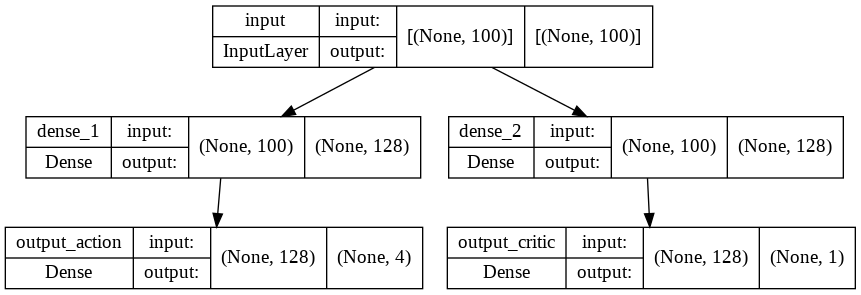

In [ ]:
inputs = tf.keras.layers.Input(shape=(num_states,), name='input')
common = tf.keras.layers.Dense(128, activation="relu", name='dense_1')(inputs)
action = tf.keras.layers.Dense(num_actions, activation="softmax", name='output_action')(common)
x = tf.keras.layers.Dense(128, activation='relu', name='dense_2')(inputs)
critic = tf.keras.layers.Dense(1, name='output_critic')(x)

model = tf.keras.Model(inputs=inputs, outputs=[action, critic])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

## Training


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
mse_loss = tf.keras.losses.MeanSquaredError()
action_probs_history = []
critic_value_history = []
rewards_history = []
mse = []
loss_actor_history = []
loss_critic_history = []
steps_per_episode = []
episode_count = 0
epochs = 5_000 # Represents the number of episodes for which the model is trained

for i in range(epochs):  # Run until solved
    state = start_state.copy()
    state = tf.convert_to_tensor(state, dtype=tf.float32)
    state = tf.expand_dims(state, 0)

    with tf.GradientTape() as tape:
        step_count = 0

        for timestep in range(1, max_steps_per_episode):

            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0, 0])

            # Randomly selecting an action from the probability distribution
            action = np.random.choice(num_actions, p=np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            state, reward, done = get_next_state(state, action)
            rewards_history.append(reward)
            step_count += 1

            if done:
                steps_per_episode.append(step_count)
                break


        # Returns computation
        returns = compute_returns(rewards_history)

        # Normalize
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns))
        returns = returns.tolist(); returns_ = returns.copy()

        # Computing losses in order to compute gradients and update our network
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            
            actor_losses.append(-log_prob * ret)  # actor loss

            critic_losses.append(
                mse_loss(tf.expand_dims(value, 0), tf.expand_dims(ret, 0))
            ) #critic loss


        # Gradients computation and model update
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Storing loss values
        loss_actor_history.append(sum(actor_losses).numpy())
        loss_critic_history.append(sum(critic_losses).numpy())


        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()

  
    episode_count += 1
    if episode_count % 10 == 0:
        print("Error {:.3f} at episode {}".format(loss_critic_history[-1], episode_count))


Error 4159.196 at episode 10
Error 150.878 at episode 20
Error 290.255 at episode 30
Error 1902.439 at episode 40
Error 720.726 at episode 50
Error 669.627 at episode 60
Error 360.183 at episode 70
Error 1295.455 at episode 80
Error 615.693 at episode 90
Error 194.406 at episode 100
Error 297.057 at episode 110
Error 261.060 at episode 120
Error 136.367 at episode 130
Error 1237.184 at episode 140
Error 666.445 at episode 150
Error 460.645 at episode 160
Error 521.693 at episode 170
Error 402.781 at episode 180
Error 36.091 at episode 190
Error 108.596 at episode 200
Error 615.186 at episode 210
Error 404.694 at episode 220
Error 54.782 at episode 230
Error 339.313 at episode 240
Error 152.029 at episode 250


# Plotting error curves

Text(0, 0.5, 'loss')

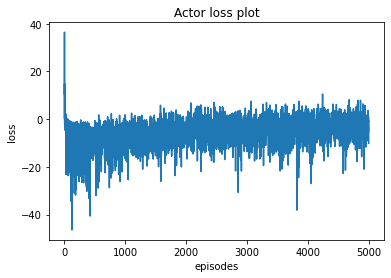

In [ ]:
# Loss plot

plt.plot(range(1,len(loss_actor_history)+1), loss_actor_history)
plt.title("Actor loss plot")
plt.xlabel("episodes")
plt.ylabel("loss")

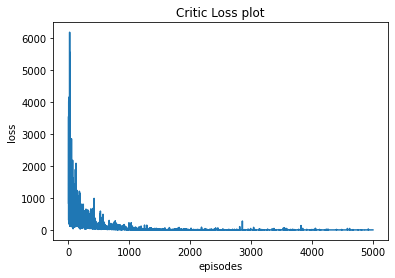

In [ ]:
# Loss plot

plt.plot(range(1,len(loss_critic_history)+1), loss_critic_history)
plt.title("Critic Loss plot")
plt.xlabel("episodes")
_ = plt.ylabel("loss")

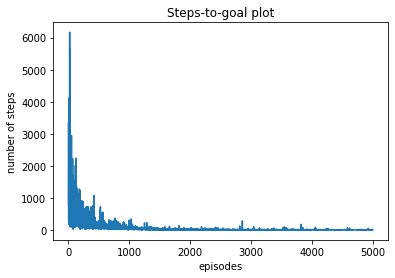

In [ ]:
 # Steps to go plot

plt.plot(range(1,len(steps_per_episode)+1), steps_per_episode)
plt.title("Steps-to-goal plot")
plt.xlabel("episodes")
_ = plt.ylabel("number of steps")

In [ ]:
mean = np.mean(steps_per_episode[-50:])
print("Mean steps-to-go for last 50 episodes", mean)

Mean steps-to-go for last 50 episodes 17.52


# Testing the trained model by simulating agent movements in the maze

In [ ]:
def get_rect(maze, i,j):
    """
    Creates a tile used to render the maze
    maze: The maze layout (numpy array)
    i,j: The row and column numbers locating a tile
    Returns an artist object used to render a tile in the maze

    """


    elt = maze[i][j]
    rect = None


    if (i,j) == start and elt == 1: # Checking if the agent is at the start position
        rect = patches.Rectangle((j, maze_size[0] - i - 1), height=1, width=1, color='#800080')         
        return rect
    elif (i,j) == start and elt == 0: # Checking if the empty cell is the start state 
        rect = patches.Rectangle((j, maze_size[0] - i - 1), height=1, width=1, color='red') 
        return rect
    elif elt == 11: # Checking if the agent has reached the goal position
        rect = patches.Rectangle((j, maze_size[0] - i - 1), height=1, width=1, color='#00FFFF')
        return rect

    if elt == 0:
        rect = patches.Rectangle((j, maze_size[0] - i - 1), height=1, width=1, color='white')
    elif elt == -1:
        rect = patches.Rectangle((j, maze_size[0] - i - 1), height=1, width=1, color='black')
    elif elt == 1:
        rect = patches.Rectangle((j, maze_size[0] - i - 1), height=1, width=1, color='blue')
    else:
        rect = patches.Rectangle((j, maze_size[0] - i - 1), height=1, width=1, color='green')


    
    return rect

In [ ]:
def render_maze(maze, step):
    """
    Renders the maze at each step of the agent's movement
    maze: The maze layout
    step: The number of steps taken by the agent
    """
    ax = plt.axes()
    _ = ax.set(xlim=(0,maze_size[1]), ylim=(0,maze_size[0]), xticks=np.arange(maze_size[1]+1), yticks=np.arange(maze_size[0]+1))
    for i in range(11):
        plt.vlines(i, 0, 10)
        plt.hlines(i, 0, 10)

    
    for i in range(maze_size[0]):
        for j in range(maze_size[1]):
            rect = get_rect(maze, i,j)
            ax.add_patch(rect)

    ax.axes.xaxis.set_ticks([])
    ax.axes.yaxis.set_ticks([])
    plt.savefig("frame" + str(step).zfill(3) + ".png")
    plt.show()
    

In [ ]:
def simulate_grid_world(model, maze, start_state):
    """
    Simulates the movements of the agent given the trained model and the maze layout
    In the maze, 1 represents the agent and 10 the goal
    model: The trained model
    maze: The maze layout
    start_state: The agent starting state
    """
    state = start_state.copy()
    state = tf.convert_to_tensor(state, dtype=tf.float32)
    state = tf.expand_dims(state, 0)
    state_reshaped = tf.reshape(state, maze_size).numpy()
    maze_ = state_reshaped + maze
    step_count = 0
    rewards = []
    movements = ["LEFT", "RIGHT", "UP", "DOWN"]

    render_maze(maze_, step_count)
    while True:
        action_probs, _ = model(state)
        action = get_sample_action(action_probs)
        print("Actions probability distribution & action taken\n",action_probs.numpy(), movements[action])
        print("\n")
        state, reward, done = get_next_state(state, action)
        rewards.append(reward)

        state_reshaped = tf.reshape(state, maze_size).numpy()
        maze_ = state_reshaped + maze

        step_count += 1
        render_maze(maze_, step_count)
        if done:
            break

    print("Number of steps-to-goal: ", step_count)

In [ ]:
# Removing previous frames from the disk
!rm frame*
!ls

rm: cannot remove 'frame*': No such file or directory
model.png  sample_data


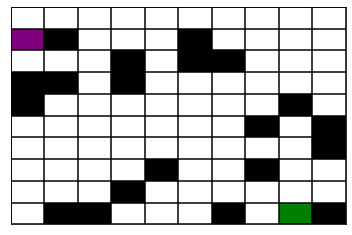

Actions probability distribution & action taken
 [[0.01841799 0.03985515 0.04193104 0.8997958 ]] DOWN




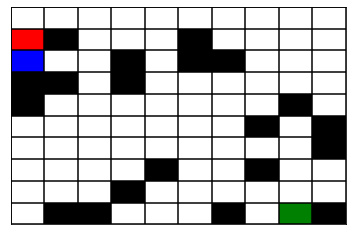

Actions probability distribution & action taken
 [[0.01886266 0.87454087 0.0550426  0.05155395]] RIGHT




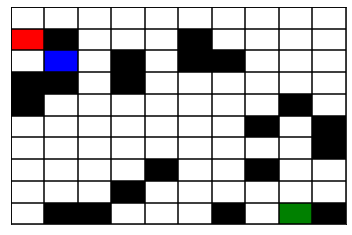

Actions probability distribution & action taken
 [[0.03845828 0.87879354 0.03135142 0.05139681]] RIGHT




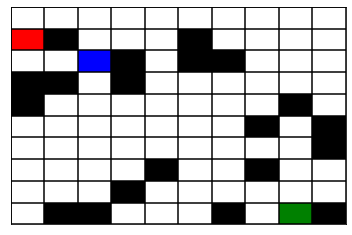

Actions probability distribution & action taken
 [[0.01147215 0.01921531 0.00926606 0.9600465 ]] DOWN




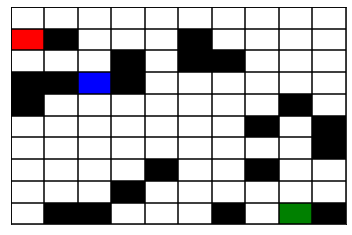

Actions probability distribution & action taken
 [[0.00675321 0.01461589 0.01150024 0.96713066]] DOWN




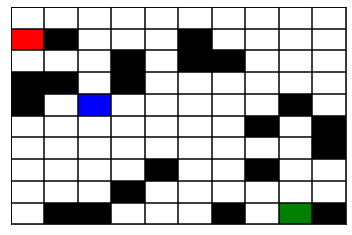

Actions probability distribution & action taken
 [[0.02586724 0.46240175 0.03848081 0.47325033]] DOWN




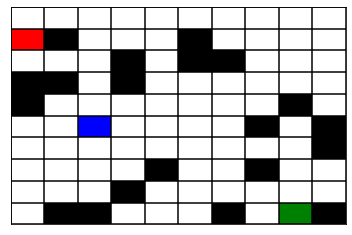

Actions probability distribution & action taken
 [[0.01734208 0.7990036  0.02461369 0.1590406 ]] RIGHT




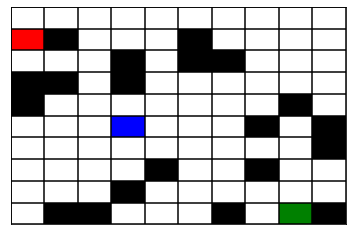

Actions probability distribution & action taken
 [[0.02098709 0.8105162  0.01821813 0.15027867]] RIGHT




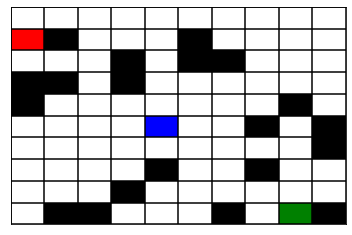

Actions probability distribution & action taken
 [[0.01599717 0.26413608 0.01451596 0.7053508 ]] DOWN




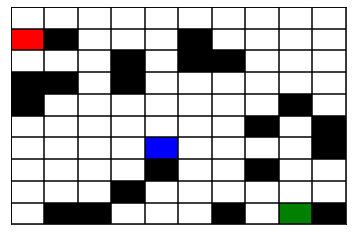

Actions probability distribution & action taken
 [[0.0028212  0.9856937  0.00602577 0.00545949]] RIGHT




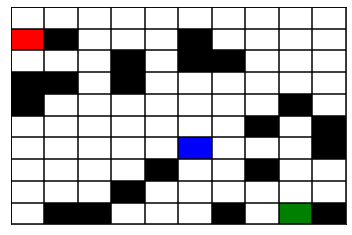

Actions probability distribution & action taken
 [[0.00600009 0.09027463 0.00902053 0.89470476]] DOWN




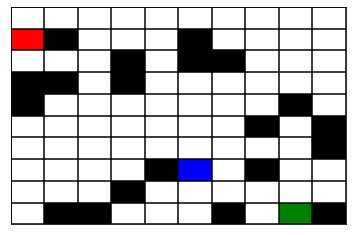

Actions probability distribution & action taken
 [[0.007569   0.59327203 0.01576506 0.3833939 ]] RIGHT




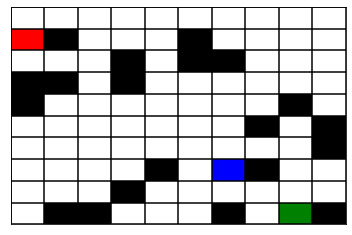

Actions probability distribution & action taken
 [[0.00712345 0.01172478 0.00611791 0.9750338 ]] DOWN




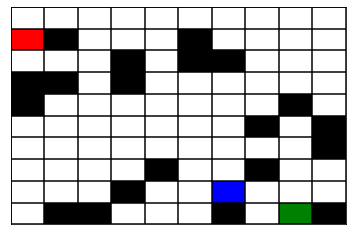

Actions probability distribution & action taken
 [[0.00233128 0.9829268  0.00412842 0.0106135 ]] RIGHT




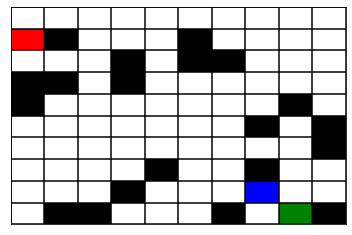

Actions probability distribution & action taken
 [[0.00503847 0.08304898 0.00541293 0.9064996 ]] DOWN




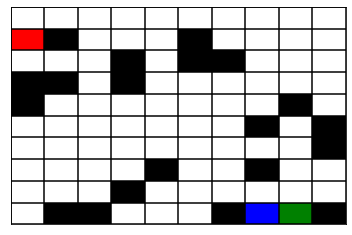

Actions probability distribution & action taken
 [[0.0064535  0.9606674  0.00584606 0.02703315]] RIGHT




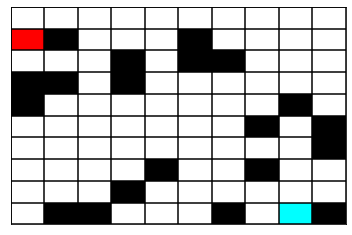

Number of steps-to-goal:  16


In [ ]:
# Defining the start state
a_state = np.zeros(maze_size)
a_state[0][1] = 1
a_state = a_state.flatten()
simulate_grid_world(model, maze, start_state)

# Creating a gif file of the agent movements

In [ ]:
def create_gif():
    """
    # Source: https://pythonprogramming.altervista.org/png-to-gif/?doing_wp_cron=1650566310.4698081016540527343750
    Creates a gif of the movements of the agent in the maze
    """
    from PIL import Image
    import glob
    
    # Creating frames
    frames = []
    imgs = glob.glob("frame*.png")
    imgs = sorted(imgs)
    for i in imgs:
        new_frame = Image.open(i)
        frames.append(new_frame)
    
    # Save frames into a GIF file
    frames[0].save('png_to_gif.gif', format='GIF',
                append_images=frames[1:],
                save_all=True,
                duration=300, loop=0)

In [ ]:
create_gif()